In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',None)
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

In [5]:
def change_time(num):
  if int(num)>=8 and int(num)<12:
    return 0
  elif int(num)>=12 and int(num)<17:
    return 1
  elif int(num)>=17 and int(num)<=23:
    return 2
  elif int(num)>=0 and int(num)<5:
    return 3
  else:
    return 4
accident_data = pd.read_parquet("./drive/MyDrive/accident_data.parquet")
accident_data = accident_data.drop(["Date"],axis=1)
accident_data = accident_data.dropna(axis=0,subset=["Time"])
accident_data["Time"] = accident_data["Time"].apply(lambda x:change_time(str(x)[:2]))

In [6]:
#Special conditions at site 15?
#Unclassified->nan
#None->nan
#Data Missing or out of range->nan
def missing_values_change(val):
    if str(val)=="Unclassified" or str(val)=='None' or str(val)=="Data missing or out of range" or str(val)=="Unallocated":
      return np.nan
    else:
      return val
for col in accident_data.columns:
  accident_data[col] = accident_data[col].apply(lambda x:missing_values_change(x))

In [7]:
accident_data.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,NaN,Tuesday,1.0,NaN,Not at junction or within 20 metres,51.489096,NaN,Kensington and Chelsea,Kensington and Chelsea,525680.0,178240.0,-0.191170,E01002849,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30,2,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,NaN,Wednesday,1.0,Auto traffic signal,Crossroads,51.520075,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,-0.211708,E01002909,1,1,0.0,5.0,Metropolitan Police,Dry,Dual carriageway,NaN,30,2,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,NaN,Thursday,1.0,NaN,Not at junction or within 20 metres,51.525301,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,-0.206458,E01002857,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30,3,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,NaN,Friday,1.0,NaN,Not at junction or within 20 metres,51.482442,NaN,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,-0.173862,E01002840,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30,0,Urban,Fine no high winds,2005,No
4,200501BS00005,NaN,0.0,NaN,0.0,Slight,NaN,Monday,1.0,NaN,Not at junction or within 20 metres,51.495752,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,-0.156618,E01002863,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30,2,Urban,Fine no high winds,2005,No


In [8]:
#What percentage are missing values
ncounts = pd.DataFrame([accident_data.isna().mean()]).T
ncounts.columns=["percentage_missing"]

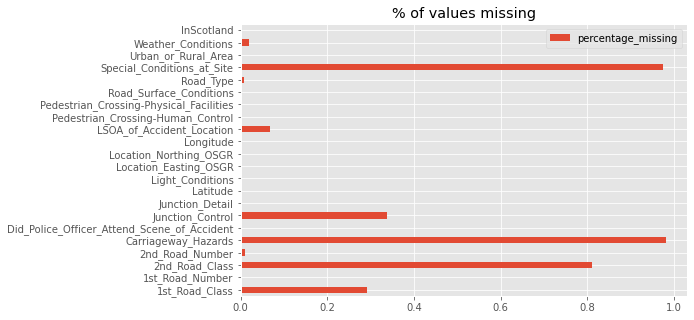

In [9]:
ncounts.query("percentage_missing>0").plot(kind="barh",figsize=(8,5),title='% of values missing')

In [10]:
cols_to_fill = list(ncounts.query("percentage_missing>0.01").index)  #Number of features where more than 1% of values are missing

In [11]:
cols_to_fill

['1st_Road_Class',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Carriageway_Hazards',
 'Junction_Control',
 'LSOA_of_Accident_Location',
 'Special_Conditions_at_Site',
 'Weather_Conditions']

In [12]:
subset = [col for col in accident_data.columns if col not in cols_to_fill]
accident_data = accident_data.dropna(axis=0,subset=subset)

In [13]:
accident_data_missing_tag_df = accident_data[cols_to_fill].isna()
accident_data_missing_tag_df.columns = [f"{c}_missing" for c in accident_data_missing_tag_df.columns]

In [14]:
accident_data = pd.concat([accident_data,accident_data_missing_tag_df],axis=1)

In [15]:
num_cols = [col for col in accident_data.columns if accident_data[col].dtype=="float64" or accident_data[col].dtype=="int64"]
cat_cols = [col for col in accident_data.columns if col not in num_cols and (col!="Accident_Index") and col!="Accident_Severity"]

In [16]:
le = LabelEncoder()
for col in cat_cols:
  accident_data[col] = le.fit_transform(accident_data[col])

In [20]:
cols_to_fill

['1st_Road_Class',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Carriageway_Hazards',
 'Junction_Control',
 'LSOA_of_Accident_Location',
 'Special_Conditions_at_Site',
 'Weather_Conditions']

In [17]:
X = accident_data.drop(["Accident_Severity"],axis=1)
y = accident_data.Accident_Severity
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
it_imptr = IterativeImputer(max_iter=10)
features = [f for f in cols_to_fill]
X_train_imputed = it_imptr.fit_transform(X_train[features])
X_valid_imputed = it_imptr.transform(X_valid[features])


X_train_imputed = pd.DataFrame(X_train_imputed,columns=features)
X_valid_imputed = pd.DataFrame(X_valid_imputed,columns=features)

X_train_imputed.index = X_train.index
X_valid_imputed.index = X_valid.index

X_train_final = pd.concat([X_train.drop(cols_to_fill,axis=1),X_train_imputed],axis=1)
X_valid_final = pd.concat([X_valid.drop(cols_to_fill,axis=1),X_valid_imputed],axis=1)

In [19]:
X_train_final.head()

,Accident_Index,1st_Road_Number,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Year,InScotland,1st_Road_Class_missing,2nd_Road_Class_missing,2nd_Road_Number_missing,Carriageway_Hazards_missing,Junction_Control_missing,LSOA_of_Accident_Location_missing,Special_Conditions_at_Site_missing,Weather_Conditions_missing,1st_Road_Class,2nd_Road_Class,2nd_Road_Number,Carriageway_Hazards,Junction_Control,LSOA_of_Accident_Location,Special_Conditions_at_Site,Weather_Conditions
573246,200801EO40220,104.0,6,1.0,8,51.542734,4,183,91,532430.0,184380.0,-0.091697,1,2,0.0,0.0,29,0,3,30,0,1,2008,0,0,1,0,1,0,0,1,0,0.0,5.0,0.0,5.0,3.0,2699.0,9.0,1.0
669208,2.00836E+12,1135.0,0,1.0,3,52.660709,4,38,122,599930.0,311100.0,0.954875,2,2,0.0,0.0,30,4,3,60,0,0,2008,0,0,1,0,1,1,0,0,0,2.0,5.0,0.0,5.0,6.0,26304.0,5.0,5.0
688836,2.00844E+12,0.0,0,1.0,3,51.241688,4,18,77,460530.0,149530.0,-1.134264,1,1,0.0,0.0,20,0,3,30,1,1,2008,0,1,1,0,1,1,0,1,0,5.0,5.0,0.0,5.0,6.0,22408.0,9.0,1.0
203909,200601HT20016,11.0,6,1.0,8,51.522313,4,372,190,535930.0,182200.0,-0.042098,1,1,0.0,4.0,29,4,3,30,0,1,2006,0,0,0,0,1,0,0,1,0,0.0,3.0,0.0,5.0,3.0,4228.0,9.0,5.0
656409,20083102B3652,6024.0,0,1.0,5,53.304087,4,19,134,458440.0,378930.0,-1.124487,1,1,0.0,5.0,36,4,3,30,1,1,2008,0,0,1,0,1,0,0,1,0,2.0,5.0,0.0,5.0,3.0,27935.0,9.0,1.0


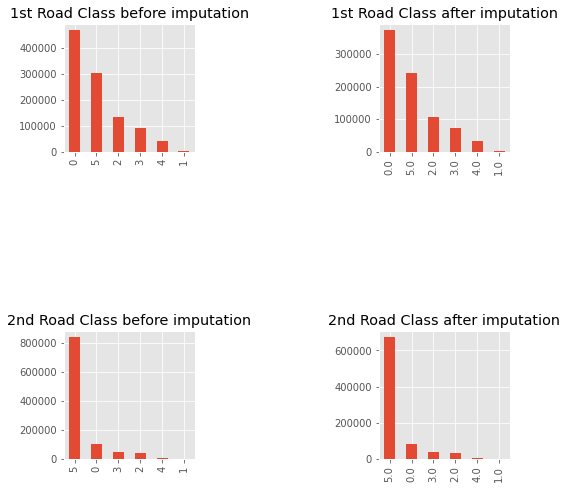

In [17]:
plt.subplot(3,3,1)
accident_data["1st_Road_Class"].value_counts().plot(kind="bar",title="1st Road Class before imputation",figsize=(8,8))
plt.subplot(3,3,3)
X_train_final["1st_Road_Class"].value_counts().plot(kind="bar",title="1st Road Class after imputation",figsize=(8,8))
plt.subplot(3,3,7)
accident_data["2nd_Road_Class"].value_counts().plot(kind="bar",title="2nd Road Class before imputation",figsize=(8,8))
plt.subplot(3,3,9)
X_train_final["2nd_Road_Class"].value_counts().plot(kind="bar",title="2nd Road Class after imputation",figsize=(8,8))

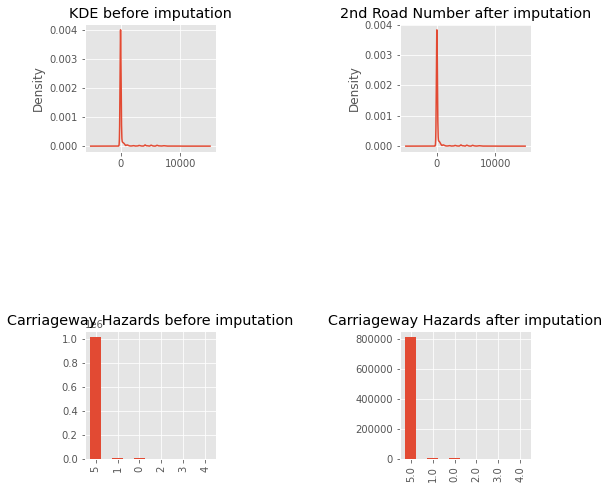

In [18]:
plt.subplot(3,3,1)
accident_data["2nd_Road_Number"].plot(kind="kde",title="KDE before imputation",figsize=(8,8))
plt.subplot(3,3,3)
X_train_final["2nd_Road_Number"].plot(kind="kde",title="2nd Road Number after imputation",figsize=(8,8))
plt.subplot(3,3,7)
accident_data["Carriageway_Hazards"].value_counts().plot(kind="bar",title="Carriageway Hazards before imputation",figsize=(8,8))
plt.subplot(3,3,9)
X_train_final["Carriageway_Hazards"].value_counts().plot(kind="bar",title="Carriageway Hazards after imputation",figsize=(8,8))

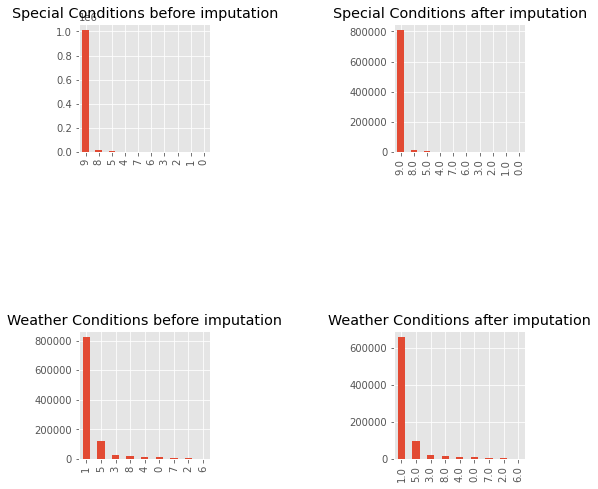

In [22]:
plt.subplot(3,3,1)
accident_data["Special_Conditions_at_Site"].value_counts().plot(kind="bar",title="Special Conditions before imputation",figsize=(8,8))
plt.subplot(3,3,3)
X_train_final["Special_Conditions_at_Site"].value_counts().plot(kind="bar",title="Special Conditions after imputation",figsize=(8,8))
plt.subplot(3,3,7)
accident_data["Weather_Conditions"].value_counts().plot(kind="bar",title="Weather Conditions before imputation",figsize=(8,8))
plt.subplot(3,3,9)
X_train_final["Weather_Conditions"].value_counts().plot(kind="bar",title="Weather Conditions after imputation",figsize=(8,8))

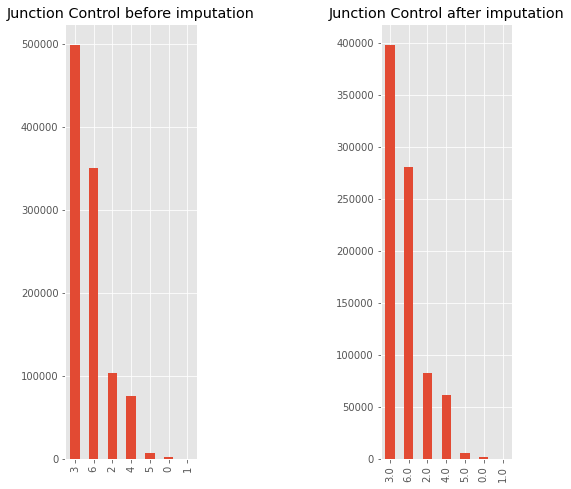

In [20]:
plt.subplot(1,3,1)
accident_data["Junction_Control"].value_counts().plot(kind="bar",title="Junction Control before imputation",figsize=(8,8))
plt.subplot(1,3,3)
X_train_final["Junction_Control"].value_counts().plot(kind="bar",title="Junction Control after imputation",figsize=(8,8))